## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources.So we built a generator with the ImageDataGenerator generator. 

The label file will be loaded as an usual CSV file.

In [3]:
# loading the label file
labels = pd.read_csv('/datasets/faces/labels.csv')

# loading the images file using Image Generator
train_datagen = ImageDataGenerator(rescale = 1./255)

train_flow = train_datagen.flow_from_dataframe(
dataframe = labels,
directory = '/datasets/faces/final_files/',
x_col = 'file_name',
y_col = 'real_age',
target_size = (224,224),
batch_size = 32,
class_mode = 'raw',
seed = 12345)

Found 7591 validated image filenames.


## EDA

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.duplicated().sum()

0

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

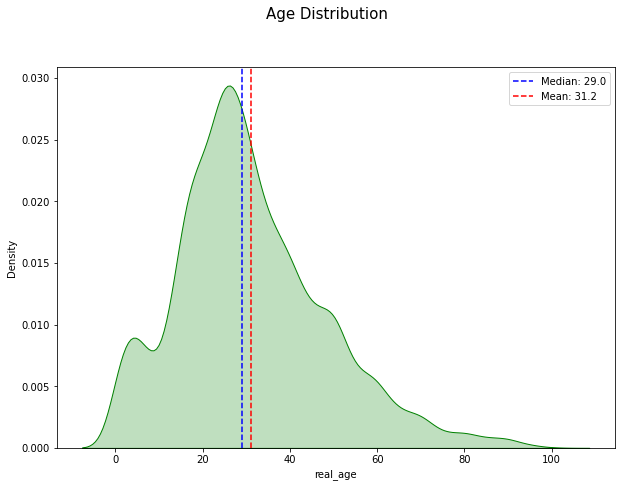

In [8]:
fig = plt.figure(figsize =(10, 7))
fig.suptitle('Age Distribution', fontsize=15, y=1)
sns.kdeplot(labels['real_age'], fill = True, color = 'green')

plt.axvline(x = labels['real_age'].median(),
            color='blue',
            ls='--', 
            lw=1.5, 
            label = 'Median: {}'.format(round(labels['real_age'].median(),2)))

plt.axvline(x = labels['real_age'].mean(),
            color='red',
            ls='--', 
            lw=1.5, 
            label = 'Mean: {}'.format(round(labels['real_age'].mean(),2)))
plt.legend()
plt.show()

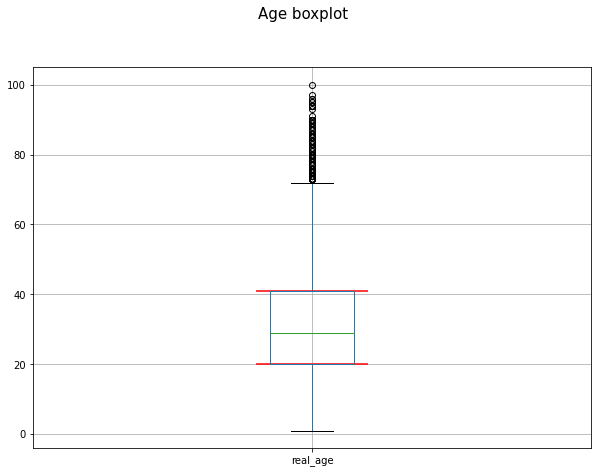

In [9]:
fig = plt.figure(figsize =(10, 7))
fig.suptitle('Age boxplot', fontsize=15, y=1)
labels.boxplot('real_age')
Q1 = labels['real_age'].quantile(0.25)
Q3 = labels['real_age'].quantile(0.75)
plt.hlines(y=[Q1,Q3], xmin = 0.9, xmax = 1.1, color = 'red')
plt.show()

In [10]:
features, target = next(train_flow)

In [11]:
# counting how many images we have of people that not allowed
# to buy alcohol
sum(target < 21)

8

In [19]:
# building a function to find the indices of images of people 
# of different age groups
def age_index(data):
    
    # setting the youngest and oldest ages
    min_age = data.min()
    max_age = data.max()
    
    # creating temporary lists for every age decade that
    # will be combined later
    d_10 = []
    d_20 = []
    d_30 = []
    d_40 = []
    d_50 = []
    d_60 = []
    d_70 = []
    d_80 = []
    d_90 = []
    
    # creating a list that will combine all the indices
    decade_indices = []
    
    # adding the youngest age index to the main indices list
    decade_indices.append(np.where(data == min_age)[0][0])
    
    # creating a loop that will iterate on every element in the target 
    # array that have the real ages of the people in the images
    
    for i in range(len(data)):
        
        if ((data[i] == min_age) | (data[i] == max_age)):
            continue
        
        if (data[i] <= 10) & (len(d_10) == 0):
            ind = np.where(data == data[i])[0][0]
            d_10.append(ind)
            
        if (10 < data[i] <= 20) & (len(d_20) == 0):
            ind = np.where(data == data[i])[0][0]
            d_20.append(ind)
            
        if (20 < data[i] <= 30) & (len(d_30) < 3):
            ind = np.where(data == data[i])[0][0]
            d_30.append(ind)
            
        if (30 < data[i] <= 40) & (len(d_40) < 3):
            ind = np.where(data == data[i])[0][0]
            d_40.append(ind)
            
        if (40 < data[i] <= 50) & (len(d_50) == 0):
            ind = np.where(data == data[i])[0][0]
            d_50.append(ind)
            
            
        if (50 < data[i] <= 60) & (len(d_60) == 0):
            ind = np.where(data == data[i])[0][0]
            d_60.append(ind)
            
        if (60 < data[i] <= 70) & (len(d_70) == 0):
            ind = np.where(data == data[i])[0][0]
            d_70.append(ind)
            
        if (70 < data[i] <= 80) & (len(d_80) == 0):
            ind = np.where(data == data[i])[0][0]
            d_80.append(ind)
            
        if (80 < data[i] <= 90) & (len(d_90) == 0):
            ind = np.where(data == data[i])[0][0]
            d_90.append(ind)
            
    # setting a list with all the indices lists
    ind_lists = [d_10, d_20, d_30, d_40, d_50, d_60, d_70,
              d_80, d_90]
    
    # combining all the indices to one list using a loop
    for j in range(len(ind_lists)):
        decade_indices = decade_indices + ind_lists[j]
        
    # adding the index of the image of the oldest customer
    decade_indices.append(np.where(data == max_age)[0][0])
    
    return decade_indices

In [20]:
age_ind = age_index(target)

In [21]:
print_images = features[age_ind]

In [22]:
len(print_images)

14

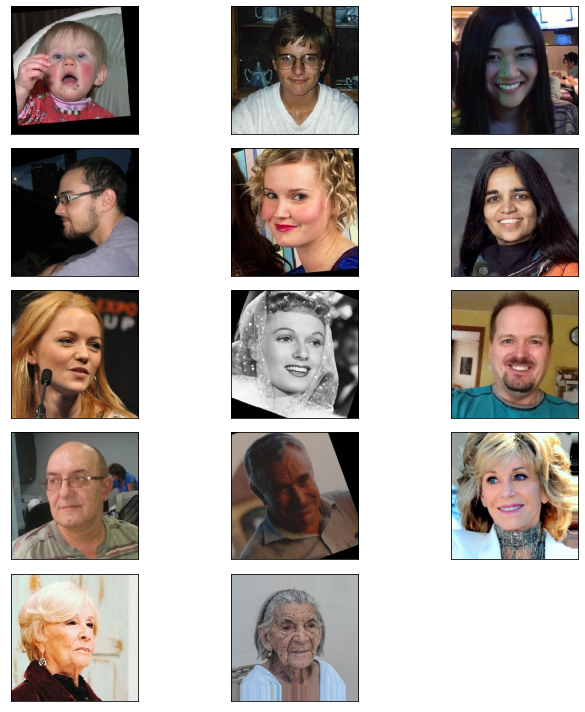

In [23]:
fig = plt.figure(figsize=(10,10))
for i in range(len(print_images)):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(print_images[i])
    # remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

The data consists of images of people of a wide range of ages. We have images of 2 years old kids, and 30 years old adults, and 95 years old pensioner. the average age of a customer is 30 while most of the customers that visit the store are in the range of ages 15 and 55.

Also, we have only 32 images, which is a tiny amount of data. although the data is distributed in a way that almost half of the images are of customers below the age of 21, we still need a larger dataset to train a good model that will know to identify correctly the age of the customers.

## Modelling

Now we will define the necessary functions to train the model on the GPU platform and build a single script containing all of them along with the initialization section.

In [24]:
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv') 
    
    datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0 / 255)
    
    train_gen_flow = datagen.flow_from_dataframe(
    dataframe = labels,
        directory = (path+'final_files/'),
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345)
    
    return train_gen_flow

In [25]:
def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    
    datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0 / 255)
    
    test_gen_flow = datagen.flow_from_dataframe(
    dataframe = labels,
        directory = (path+'final_files/'),
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'validation',
        seed = 12345)
    
    return test_gen_flow

In [26]:
def create_model(input_shape=(224,224, 3)):
    
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    
    model = Sequential()
                        
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    
    model.compile(
        optimizer = optimizer,
        loss='mean_squared_error',
        metrics=['mean_absolute_error'],
    )
    return model

In [27]:
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=10,
    steps_per_epoch=None,
    validation_steps=None,
):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data) 
        
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

## Prepare the Script to Run on the GPU Platform

No that we defined the necessary functions, we will compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

In [28]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output


2022-07-09 16:52:36.647572: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-07-09 16:52:36.649399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-07-09 16:52:37.572159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-09 16:52:38.249749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-09 16:52:38.249839: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 16:52:38.249871: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-09 16:52:38.251841: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-09 16:52:38.252331: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-07-09 16:52:38.254844: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-07-09 16:52:38.256186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-07-09 16:52:38.256271: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-07-09 16:52:38.261207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-09 16:52:38.261548: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-07-09 16:52:38.268440: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-07-09 16:52:38.269101: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x58c80b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-09 16:52:38.269133: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-07-09 16:52:38.412251: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x594e0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-07-09 16:52:38.412290: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-07-09 16:52:38.415047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-07-09 16:52:38.415127: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 16:52:38.415143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-09 16:52:38.415189: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-07-09 16:52:38.415210: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-07-09 16:52:38.415229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-07-09 16:52:38.415246: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-07-09 16:52:38.415259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-07-09 16:52:38.419783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-07-09 16:52:38.419859: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-07-09 16:52:38.737626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-07-09 16:52:38.737678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-07-09 16:52:38.737689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-07-09 16:52:38.742525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-07-09 16:52:49.959184: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-09 16:52:50.256390: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 240.4333 - mean_absolute_error: 11.1785 - val_loss: 763.6682 - val_mean_absolute_error: 22.7077
Epoch 2/10
178/178 - 37s - loss: 62.9672 - mean_absolute_error: 6.0413 - val_loss: 663.6705 - val_mean_absolute_error: 20.4714
Epoch 3/10
178/178 - 37s - loss: 31.5299 - mean_absolute_error: 4.3181 - val_loss: 290.2633 - val_mean_absolute_error: 12.6989
Epoch 4/10
178/178 - 37s - loss: 19.0870 - mean_absolute_error: 3.3704 - val_loss: 116.6869 - val_mean_absolute_error: 8.1234
Epoch 5/10
178/178 - 37s - loss: 14.2343 - mean_absolute_error: 2.9335 - val_loss: 79.5347 - val_mean_absolute_error: 6.7151
Epoch 6/10
178/178 - 37s - loss: 11.9214 - mean_absolute_error: 2.6679 - val_loss: 72.2106 - val_mean_absolute_error: 6.3974
Epoch 7/10
178/178 - 37s - loss: 9.7385 - mean_absolute_error: 2.3954 - val_loss: 68.3491 - val_mean_absolute_error: 6.2175
Epoch 8/10
178/178 - 37s - loss: 8.2329 - mean_absolute_error: 2.2080 - val_loss: 66.9727 - val_mean_absolute_error: 6.1325
Epoch 9/10
178/178 - 37s - loss: 7.3581 - mean_absolute_error: 2.0353 - val_loss: 70.1773 - val_mean_absolute_error: 6.2400
Epoch 10/10
178/178 - 37s - loss: 7.0166 - mean_absolute_error: 1.9976 - val_loss: 67.6142 - val_mean_absolute_error: 6.2218
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 67.6142 - mean_absolute_error: 6.2218
Test MAE: 6.2218

## Conclusions

In this project, we built a model which will predict the age of the person that is in the image, so the store could automatically know the age of the customers, and by that lower the probability that alcoholic beverages will be sold to underage customers. 

First, we loaded that data, and then examined it. We checked consumers' age distribution and saw that the customer's age varies and includes all the ages. The store visit kids, teenagers, adults, and older people (make sense). Also, we saw that we don't have a large amount of data, but we worked with what we had. Most of the customers that visit the store are on age between the ages of 15 and 55 when the average age of a customer is 30 and the oldest customer (that his image was in the dataset) is 95 years old. 

Afterward, we built a **Linear Regression** model using **deep learning** methodology with the **ResNet architecture**. The results of the model are quite good - the **MAE** metric was **beneath 6.5** after only 10 epochs. So basically our model is quite good at identifying people's ages from a photo. 

Another usage of this model that we would suggest to the store is targeting advertising. People of different ages have different products that interest them, so by knowing the customer's age, tailored advertising can be made for each customer, and that can rise the store's sales. 